In [ ]:
print("""
The prevailing rate that people are used to paying for rides from the airport to downtown (either direction, one way) is 25. The prevailing wage that drivers are used to earning for this trip is 19.

You launch with exactly this price: 25 per ride charged to the rider, 19 per ride paid to the driver. It turns out only 60 or so of every 100 rides requested are finding a driver at this price.

(While there is more than one route to think about in Toledo, for the sake of this exercise you can focus on this one route.)

Here’s your current unit economics for each side:

Drivers:

Customer acquisition cost (CAC) of a new working driver is roughly $500

At the prevailing wage, drivers have a 5% monthly churn rate and complete 100 rides / month

Riders:

CAC of a new rider is $10 to $20 (it’s sensitive to the rate of acquisition, since existing marketing channels are only so deep)

Each rider requests 1 ride / month on average

Churn is interesting: riders who don’t experience a “failed to find driver” event churn at 10% monthly, but riders who experience one or more “failed to find driver” events churn at 33% monthly

You’ve run one pricing experiment so far: when you reduced Lyft’s take from $6/ride to $3/ride across the board for a few weeks, match rates rose nearly instantly from 60% to roughly 93%.

Your task is to maximize the company’s net revenue (the difference between the amount riders pay and the amount Lyft pays out to drivers) for this route in Toledo for the next 12 months. Let’s assume that you cannot charge riders more than the prevailing rate.

The core question is: how much more or less do you pay drivers per trip (by changing Lyft’s take)? Your goal is to maximize net revenue for the next 12 months on this route
""")


The prevailing rate that people are used to paying for rides from the airport to downtown (either direction, one way) is 25. The prevailing wage that drivers are used to earning for this trip is 19.

You launch with exactly this price: 25 per ride charged to the rider, 19 per ride paid to the driver. It turns out only 60 or so of every 100 rides requested are finding a driver at this price.

(While there is more than one route to think about in Toledo, for the sake of this exercise you can focus on this one route.)

Here’s your current unit economics for each side:

Drivers: 

Customer acquisition cost (CAC) of a new working driver is roughly $500

At the prevailing wage, drivers have a 5% monthly churn rate and complete 100 rides / month

Riders: 

CAC of a new rider is $10 to $20 (it’s sensitive to the rate of acquisition, since existing marketing channels are only so deep) 

Each rider requests 1 ride / month on average

Churn is interesting: riders who don’t experience a “failed t

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

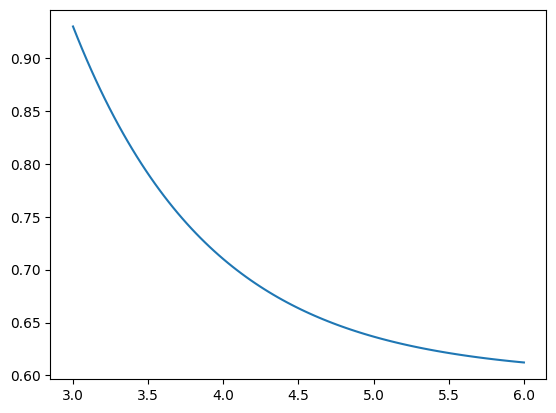

In [ ]:
## Investigate pricing multiplier

pricing = 3 + np.linspace(0,1,100)*3
match_rate = 0.6 + np.power((1/3),pricing) /max(np.power((1/3),pricing))*(0.93-0.6)
sns.lineplot(x=pricing,y=match_rate)

In [ ]:
def match_rate(x):

  y= 0.6 + pow((1/3),x) / pow((1/3),3)*(0.93-0.6)

  if y>1 :
    return 1
  else :
    return y

In [ ]:
match_rate(6)

0.6122222222222222

In [ ]:
# ## Investigate pricing multiplier

# pricing = np.linspace(0,25,100)
# match_rate = np.power((1/3),pricing) + 92.95
# sns.lineplot(x=pricing,y=match_rate)



# def match_rate_new(x):

#   y= pow((1/3),x) + 0.89
#   print(pow((1/3),x))
#   print(y)

#   if y>1 :
#     return 1
#   else :
#     return y

# match_rate_new(6)

<Axes: >

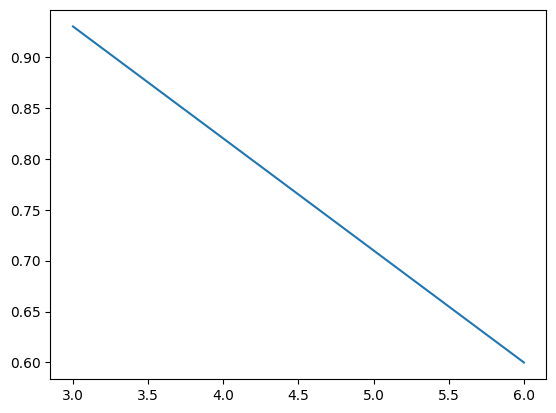

In [ ]:
pricing = np.linspace(3,6,100)
match_rate = np.linspace(0.93,0.6,100)

sns.lineplot(x=pricing,y=match_rate)

In [ ]:
def match_rate(x):

  slope = (0.93-0.6)/(3-6)
  y_intercept = round(0.93 - slope*3,3)

  y = slope*x + y_intercept

  if y>1 :
    return 1
  if y<=0 :
    return 0.0001
  else :
    return y

In [ ]:
match_rate(4)

0.8199999999999998

In [ ]:
df = pd.DataFrame()

def optimizer(x, disp=False):

  for i in range(1,13):

    #income
    df.loc['months',i] = "M"+str(i)
    df.loc['prevailing_rate',i] = 25

    #driver
    df.loc['drivers_per_month',i] = 1
    df.loc['rides_per_month_per_driver',i] = 100
    df.loc['driver_churn',i] = 0.05
    df.loc['single_driver_CAC',i] = 500

    #customer
    df.loc['request_per_customer_per_month',i] = 1
    df.loc['single_customer_CAC',i] = 15 #np.random.randint(10,20)

    #variables
    df.loc['gross_revenue',i] = x[0]
    df.loc['match_rate',i] = match_rate(df.loc['gross_revenue',i])

    #calculations
    df.loc['cutomer_churn',i] = 0.33*(1-df.loc['match_rate',i]) + 0.1*(df.loc['match_rate',i])

    if i==1 :
      df.loc['drivers_per_month',i] = 1
    else :
      df.loc['drivers_per_month',i] = df.loc['drivers_per_month',i-1]*(1-df.loc['driver_churn',i])

    df.loc['rides_per_month',i] = df.loc['rides_per_month_per_driver',i]*df.loc['drivers_per_month',i]

    df.loc['customer_request_per_month',i] = df.loc['rides_per_month',i]/df.loc['match_rate',i]

    df.loc['customers_per_month',i] = df.loc['customer_request_per_month',i]/df.loc['request_per_customer_per_month',i]

    if i==1 :
      df.loc['new_customers_per_month',i] = df.loc['customers_per_month',i]
    else :
      df.loc['new_customers_per_month',i] = (df.loc['customers_per_month',i-1]*df.loc['cutomer_churn',i]) - (df.loc['rides_per_month',i-1]-df.loc['rides_per_month',i]  )

    #income
    df.loc['income',i] =  df.loc['rides_per_month',i] * df.loc['prevailing_rate',i]

    #Costs
    df.loc['driver_share',i] = df.loc['rides_per_month',i] * ( df.loc['prevailing_rate',i] - df.loc['gross_revenue',i])

    #CAC
    df.loc['total_customer_CAC',i] = df.loc['new_customers_per_month',i]*df.loc['single_customer_CAC',i]

    if i == 1 :
      df.loc['total_driver_CAC',i] = df.loc['single_driver_CAC',i]*df.loc['drivers_per_month',i]
    else :
      df.loc['total_driver_CAC',i] = 0

    #final_revenue
    df.loc['net_revenue',i] = df.loc['rides_per_month',i]*df.loc['gross_revenue',i] - df.loc['total_customer_CAC',i] - df.loc['total_driver_CAC',i]

  if disp==True:
    display(df)

  return -df.loc['net_revenue',:].sum()


In [ ]:
%%time
from scipy.optimize import differential_evolution

bounds = [(0, 25)]
res = differential_evolution(
    optimizer, bounds, maxiter=300, polish=False,disp=False
)
res

CPU times: user 3.13 s, sys: 5.29 ms, total: 3.13 s
Wall time: 3.17 s


 message: Optimization terminated successfully.
 success: True
     fun: 234.82211457303202
       x: [ 3.900e+00]
     nit: 8
    nfev: 135

In [ ]:
x =  res['x']

print("Lyft Take Rate : ", x[0])

optimizer(x=x,disp=True)
print("\n\n\nFULLprofit\n",df.loc['net_revenue',:].sum())

Lyft Take Rate :  3.90035003931456


,1,2,3,4,5,6,7,8,9,10,11,12
months,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
prevailing_rate,25,25,25,25,25,25,25,25,25,25,25,25
drivers_per_month,1,0.95,0.9025,0.857375,0.814506,0.773781,0.735092,0.698337,0.66342,0.630249,0.598737,0.5688
rides_per_month_per_driver,100,100,100,100,100,100,100,100,100,100,100,100
driver_churn,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
single_driver_CAC,500,500,500,500,500,500,500,500,500,500,500,500
request_per_customer_per_month,1,1,1,1,1,1,1,1,1,1,1,1
single_customer_CAC,15,15,15,15,15,15,15,15,15,15,15,15
gross_revenue,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035,3.90035
match_rate,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961,0.830961




Land Lele
FULLprofit
 -234.82211457303202
